In [128]:
# Pre-requisition
#!python -m pip install pmdarima
#!python -m pip install arch

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
import statsmodels.tsa.api as sm
import pmdarima as pm
sb.set()

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

In [144]:
train = pd.read_csv("../../Data/AAPLTrain.csv",parse_dates=['Date'],index_col=['Date'])
test = pd.read_csv("../../Data/AAPLTest.csv",parse_dates=['Date'],index_col=['Date'])

In [145]:
train = train.loc[lambda x : x.index > dt.datetime(2012,12,31)]
df = pd.concat([train,test])
train["Rtx"] = df["Rtx"].loc[train.index[:-1]]
train = train.dropna()

# Modelling

Before applying ARIMA, the time series have to be modelled into a stationary process.

First,the graph have to be checked whether it is a stationary process. By using **Dickey-Fuller** test, it is able to verify on the status of the graph.
<br/>


## Augmented Dickey-Fuller
A test to check for null hypothesis and alternate hypothesis, computing a test statistic with **p-value**

In [131]:
def tsplot(series, lags=None, figsize=(16, 8)):

    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))

    series.plot(ax=ts_ax)
    p_value = adfuller(series)[1]
    ts_ax.set_title("Time Series Analysis Plot: \n Dickey-Fuller: p={0:.5f}".format(p_value))
    sm.graphics.plot_acf(series, lags=lags, ax=acf_ax)
    sm.graphics.plot_pacf(series, lags=lags, ax=pacf_ax)
    plt.tight_layout()

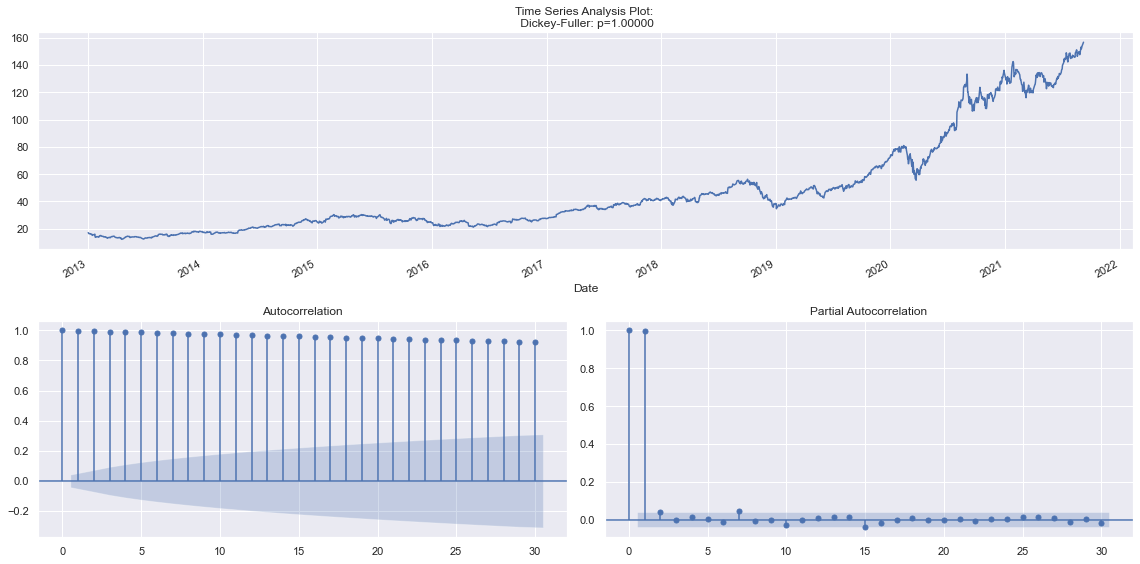

In [132]:
tsplot(train['Adj Close'], lags=30)

## Verification of Graph

Through the Dickey-Fuller test, we are able to verify that the graph is non-stationary process.
With the addition of Autocorrelation (ACF) and Partial Autocorrelation (PACF), it can be seen that there is no clear seasonality within the graph.

# ARIMA

ARIMA make use of lagged moving average to smooth time series data based on three criterias:
1. Autoregression (AR)
    * changing variable that regresses on its own lagged values (Moving Average)
2. Integrated (I)
    * Difference of raw observation to allow the time series to become stationary
3. Moving Average (MA)
    * dependency between an observation and a residual error

## Auto-ARIMA
Auto-ARIMA, a function to fill in the parameters of ARIMA through the iteration of different combination of parameters. It determines the best fitted model based on **Akaike Information Critera** (AIC).
<br/>
## What is AIC
A measure for statistical model to quantify
* goodness of fit
* Simplicity/Parsimony of the model

In [165]:
price_model = pm.auto_arima(train['Adj Close'],max_Q=4,max_P=4,max_order=20,trace=True, suppress_warnings=True,with_intercept=True)
print(price_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=inf, Time=3.62 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=8580.767, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=7756.597, Time=0.25 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=8578.768, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=7755.077, Time=0.17 sec
 ARIMA(1,2,0)(0,0,1)[4] intercept   : AIC=7756.549, Time=0.21 sec
 ARIMA(1,2,0)(1,0,1)[4] intercept   : AIC=7757.149, Time=0.60 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=7502.947, Time=0.19 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=7504.098, Time=0.23 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=7504.034, Time=0.24 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=7505.353, Time=0.75 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=7339.718, Time=0.27 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=7179.131, Time=0.58 sec
 ARIMA(3,2,0)(2,0,0)[4] intercept   : AIC=7

# AIC as determinant
To find the best fitted model, the criteria for AIC would be the lower the better.

Hence, the parameters will be determined based on the AIC.
<br/>

## Drawbacks of using AIC as a determinant

The best fitted model based on AIC might lead to a loss in parsimony by the additional AR and MA lags, thus causing the over-fitting of the model.

In [171]:
prediction = price_model.predict(n_periods=len(test))
test['Price Prediction'] = prediction

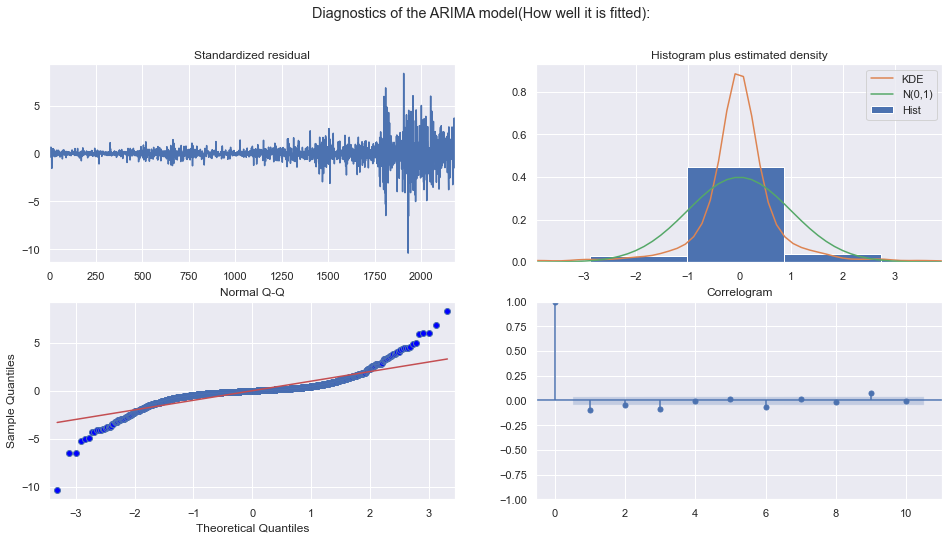

In [172]:
fig = plt.figure(figsize=(16,8))
fig.suptitle("Diagnostics of the ARIMA model(How well it is fitted):")
price_model.plot_diagnostics(fig=fig)
plt.show()

# Best Fitted Model
Explanation of Graphs (Top-Left to Bottom Right)
1. Residual Graph
2. Histogram of Residual
3. Q-Q Plot
4. AutoCorrelation (ACF)
<br/>

## Residual Graph
The residual after fitting a model. Representing the difference between the observation and corresponding fitted values (i.e.: Change in price after a day)
Used to check whether a model has adequately captured the information in the data.
 * Zero Mean
 * No correlation
<br/>

## Histogram
Used to determine the kurtosis and skewness of the residuals. Able to make calculation of prediction intervals easier based on two criteria.
 * Constant variance
 * Normally distribution
<br/>

## Q-Q Plot
Probability plot, plotting quantiles of data with quantiles of distribution. It is used to determine the distribution and skewness of the data with outliers of data.
<br/>

## ACF
By showing the ACF, it is to deduce the residuals from a white noise series, reducing the chances of false positives.
<br/>

[]

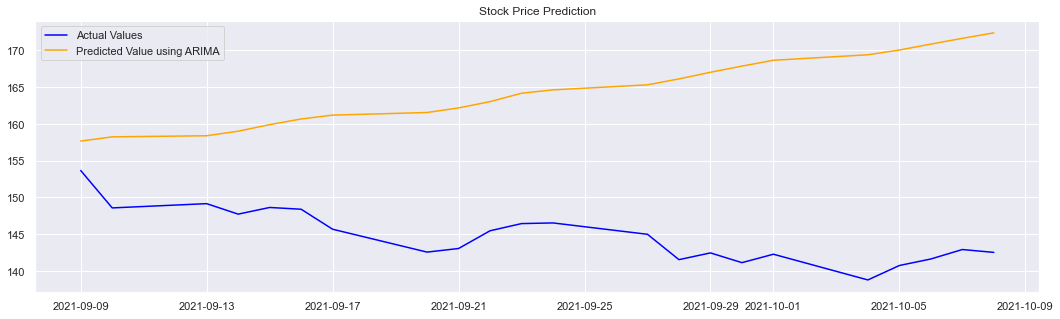

In [173]:
fig = plt.figure(figsize=(18,5))
plt.title("Stock Price Prediction")
plt.plot(test['Adj Close'], color="blue",label="Actual Values")
plt.plot(test['Price Prediction'], color="orange",label="Predicted Value using ARIMA")
plt.legend(loc='best')
plt.plot()

# Optimization of ARIMA
With the recent trend (**up**) of the stock, the prediction that ARIMA have forecasted that the price will increase.
However, when compared to the real pricing of the stock, it has gone down instead. ARIMA has limitation where it is unable to model the conditional change in variance and changes in time-dependent variance. Thus, it will require an additional model for measuring the change in variance.

## Introduction of Generalized AutoRegressive Conditional Heteroskedasticity (GARCH)
Hence, GARCH is a method that explicitly models the change in variance over time,measuring the volatility of a time series will be best suited.

In [181]:
vol_model = pm.auto_arima(train['Rtx'],max_Q=4,max_P=4,max_order=20, suppress_warnings=True,with_intercept=True)
vol_arima_pred = vol_model.predict(n_periods=len(test))

## Configuration of GARCH

Through the use of ACF and PACF, it can estimate the parameters of which GARCH model after.

In [190]:
resid = price_model.resid()
vol_arch_model = arch_model(resid,vol='GARCH',p=15,q=15)
res = vol_arch_model.fit(disp='off')
print(res.summary())
forecast = res.forecast(horizon=len(test))
garch_pred = np.array(forecast.residual_variance.dropna()).reshape(-1)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2102.00
Distribution:                  Normal   AIC:                           4268.00
Method:            Maximum Likelihood   BIC:                           4450.07
                                        No. Observations:                 2186
Date:                Fri, Apr 15 2022   Df Residuals:                     2185
Time:                        18:35:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.6829e-03  1.065e-02      0.534      0.593 

[]

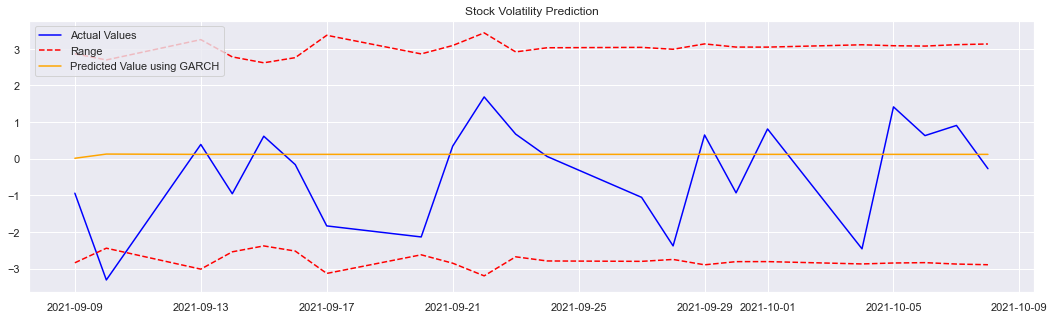

In [191]:
test['Volatility Prediction'] = vol_arima_pred
test['Upper'] = vol_arima_pred + garch_pred
test['Lower'] = vol_arima_pred - garch_pred
test['Rtx'] = df['Rtx'].loc[test.index]
fig = plt.figure(figsize=(18,5))
plt.plot(test['Rtx'], color="blue",label="Actual Values")
plt.plot(test['Upper'], color="red",linestyle="--",label="Range")
plt.plot(test['Lower'], color="red",linestyle="--")
plt.plot(test['Volatility Prediction'], color="orange",label="Predicted Value using GARCH")
plt.title("Stock Volatility Prediction")
plt.legend()
plt.plot()

## Volatility

From the graph, it is able to measure the volatility of the time series, limiting the range of price movement within 3 to -3.
By measuring the volatility, stock prices can be measured more accurately,enhancing ARIMA's model, minimizing the error in forecasting.

# Further Reading

To continue understanding the reason and application of ARIMA-GARCH, please continue on to the [documentation](../../Docs/exploring_analysis.md).

# Further Optimization

ARIMA-GARCH Prediction still have its limitation. Both utilized the past in order to forecast the future movement of the stock. Hence, when an anonymity happens which leads to the sudden increase/decrease of a stock, it is unable to predict.

Thus, it has become very important to include other factors which can affect the movement of the price.
Such models such as Long-Short Term Memory (LSTM) and Classification of News can mitigate error rate for the prediction.
 * For further explanation of [Classification](../Classification/RegressionTree.ipynb)
 * For further explanation of [LSTM](../LSTM/LSTMPrediction.ipynb)